# Chapter 6. Neural net for Classification and Regression

## 6-1. Deep learning frameworks : 
- a library for deep learning which supports
    - __Tensor__ : n-dim array (of numpy) + $\alpha$
        * basic unit of data flow in computation graph
    - __Computation graph__ of tensors
        * graph representing __flow of tensors__ (from input to output to loss)
        * __augo-gradient__ is provided
            * optimization using __gradient descent__
            * it is called __back-propagation__
                - __gradient__ information __flows backward__ in computation graph 
                - from loss to output to input
    - Computation can utilize __GPU__ very easily
        * with minimal effort of model developer

<img src="figures/Ch6.Pytorch.png" width=600>

<img src="figures/Ch6.Installing Pytorch.png" width=600>

<img src="figures/Ch6.Tensor.png" width=600>

<img src="figures/Ch6.Tensor2.png" width=600>

<img src="figures/Ch6.Tensor3.png" width=600>

## &nbsp;
## &nbsp;

## 6-2. Neural Net

<img src="figures/Ch6.Neural net.png" width=600>

<img src="figures/Ch6.SLP.png" width=600>
  
  

# &nbsp;
### Training NN for only one data $(x,y)$
<img src="figures/Ch6.Training NN.png" width=600>

### Training NN for training data set $\{(x^{(i)},y^{(i)}); i\in D_{train}\}$
- loss function = objective function to minimize
- gradient descent method
<img src="figures/Ch6.Training NN Loss.png" width=600>

#### Entropy, Cross-entropy, KL divergence : Information theory by Shannon 
- consider a probabilty distribution $\mathbf{p} = (p_1, ..., p_K)$ 
- __entropy__ $H(\mathbf{p}) = -\sum_{x=1}^K p_x\log p_x$
    - $H(\mathbf{p})$ : amount of information, level of randomness
    - $H(\mathbf{p})$ attains maximum when $\mathbf{p}$ is [____________]
        * $p_x = \frac{1}{K} \to H(\mathbf{p}) = \log K$
    - $H(\mathbf{p})=0$ (minimum), when $p_c = 1$ and $p_x = 0$ for all other $x$
- __cross-entrpy__ $H(\mathbf{p}, \mathbf{q}) = -\sum_{x=1}^K p_x\log q_x$
    - $\mathbf{q} = (q_1, ..., q_K)$ : another distribution
    - $H(\mathbf{p}, \mathbf{q})$ attains minimum when $\mathbf{p} = \mathbf{q}$
- __KL (Kullback-Leibler) divergence__  $KL(\mathbf{p}, \mathbf{q}) = D_{KL}(\mathbf{p} || \mathbf{q})$
    - $KL(\mathbf{p}, \mathbf{q}) = -\sum_{x=1}^K p_x\log \frac{q_x}{p_x}$
    - $KL(\mathbf{p}, \mathbf{q}) = -\sum_{x=1}^K p_x\log q_x + \sum_{x=1}^K p_x\log p_x = H(\mathbf{p}, \mathbf{q}) - H(\mathbf{p})$
    - $KL(\mathbf{p}, \mathbf{q}) \ne KL(\mathbf{q}, \mathbf{p})$
- Entropy is also defined for continuous distribution pdf $p(x)$
    - $H(\mathbf{p}) = -\int_D p(x)\log p(x) dx$
    - $H(\mathbf{p}, \mathbf{q}) = -\int_D p(x)\log q(x) dx$
    - $KL(\mathbf{p}, \mathbf{q}) = -\int_D p(x)\frac{q(x)}{p(x)} dx$$

## 6-3. Training NN by back-propagation
- how to compute gradient : auto-gradient (back-propagation thru computation graph)

<img src="figures/Ch6.Training NN Opt.png" width=600>

<img src="figures/Ch6.Backprop.png" width=600>

## 6-4. NN for classigying MNIST data 
### SLP (Single Layer Perceptron) 
<img src="figures/Ch6.SLP for MNIST.png" width=600>

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time

### 6-4-1. class NN_classifier
* __members__
    * n_class : # of classes
    * __nn_model__ : neural net model
    * opt : optimizer
    * train_loader : training data loader
    * test_loader : test data loader
* __methods__
    * __prepare_data__() : prepare training data and test data
    * fit_epoch() : fit nn_model using 1-epoch of training data
    * __fit__() : fit nn_model for several epochs of training data
    * accuracy() : compute accuracy score
    * test() : evaluate accuracy for test data
    * __score__() : compute accuracy score 
    * predict_proba() : compute class probability
    * __predict__() : predict class label

In [7]:
class NN_classifier:
    def __init__(self, nn_model, n_class):
        super().__init__()
        self.n_class = n_class
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.set_nn_model(nn_model)

    def set_nn_model (self, nn_model):
        self.nn_model = nn_model
        self.nn_model.to(self.device)
        self.prepare_optimizer()

    def prepare_optimizer(self, lr=0.001, wd=0.001):
        p = self.nn_model.parameters()
        # self.opt = torch.optim.SGD(p, lr=lr, momentum=0.9, weight_decay=wd)
        self.opt = torch.optim.Adam(p, lr=lr, weight_decay=wd)
        return self.opt                    
                     
    def prepare_data(self, data_class, batch_size=128):
        # trans : pipeline 1) convert to Tensor, 2) normalize to standard normal 
        if data_class == datasets.MNIST:
            mean = 0.1307
            std = 0.3081
        else:
            mean = (0.5, 0.5, 0.5)
            std = (0.5, 0.5, 0.5)
        trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
        train_set = data_class(root='data', train=True, transform=trans, download=True)
        test_set = data_class(root='data', train=False, transform=trans, download=True)
        self.train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
        
    def fit_epoch(self):
        self.nn_model.train()
        total_step = len(self.train_loader)
        incorrect = 0
        for i, (X, Y) in enumerate(self.train_loader):
            X = X.to(self.device)
            Y = Y.to(self.device)
            m = len(Y)

            # Forward pass
            out = self.nn_model(X)  # same as model.forward(images)

            # Compute loss
            loss = F.cross_entropy(out, Y)

            # Backprop
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            # Track the accuracy
            score = self.accuracy(out, Y)
            self.score_list.append(score)
            if (i+1) % 100 == 0 or (i+1)==total_step:
                print(f'Step [{i+1}/{total_step}], Loss: {loss.item():.4f}, Train acc.: {score*100:.2f}%')

    def fit(self, n_epochs=10):
        self.score_list = []
        for epoch in range(n_epochs):
            print ("Epoch %d / %d"%(epoch+1, n_epochs))
            self.fit_epoch()
        self.test()
        plt.plot(self.score_list)
        
    def accuracy(self, logit, Y, cm=None):
        total = Y.size(0)
        _, Y_hat = torch.max(logit.data, axis=1)
        correct = (Y_hat == Y).sum().item()
        acc = correct / total
        if cm is not None: # update confusion matrix
            for i in range(total):
                c = Y[i]
                p = Y_hat[i]
                cm[c][p] += 1
        return acc

    def score(self, X, Y, cm=None):
        self.nn_model.eval()
        X = X.to(self.device)
        Y = Y.to(self.device)
        with torch.no_grad():
            logit = self.nn_model(X)
        acc = self.accuracy(logit, Y, cm)        
        return acc
        
    def test(self):
        self.nn_model.eval()
        n = self.n_class
        cm = np.zeros((n,n), dtype="i")
        correct = 0
        total = 0
        for X, Y in self.test_loader:
            acc = self.score(X, Y, cm)
            n = Y.size(0)
            correct += n*acc
            total += n
        print(f'Test accuracy of the model: {correct/total*100:.2f}%')
        print (cm)        
    
    def predict_logit(self, X):
        self.nn_model.eval()
        X = X.to(self.device)
        logit = self.nn_model(X)
        return logit
    
    def predict_proba(self, X):
        logit = self.predict_logit(X)
        p_hat = F.softmax(logit, dim=1)
        return p_hat   

    def predict(self, X):
        logit = self.predict_logit(X)
        _, Y_hat = torch.max(logit.data, axis=1)
        return Y_hat


    def adv_example(self, x, y, eps=0.01):
        x = x.to(self.device)
        y = y.to(self.device)
        x.requires_grad_()

        with torch.enable_grad():
            # Forward pass
            out = self.nn_model(x)  # same as model.forward(images)

        # Compute loss
        loss = F.cross_entropy(out, y)

        grad = torch.autograd.grad(loss, [x])[0]
        grad = eps * grad.detach()
        xp = x.detach() + grad  # adv. example
        # sgn_grad = torch.sign(grad)
        # xp = x.detach() + sgn_grad  # adv. example
        return xp

# &nbsp;
### 6-4-2. class SLP
<img src="figures/Ch6.Class SLP.png" width=600>

* methds
    * __init__(D_in, D_out) : to prepare layers, which contains parameters ($\mathbf(w)$)
    * __forward__(x) : compute forward pass of neural net for input x
        * actual computation graph is built here $\to$ _dynamic computation graph_
            * layers defined in __init__() method are connected here

In [8]:
class SLP(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super().__init__()
        self.fc = torch.nn.Linear(D_in, D_out)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        y = self.fc(x)
        return y  # softmax is done within F.cross_entropy
        # return F.softmax(y, dim=-1)

<img src="figures/Ch6.SLP accuracy.png" width=600>

In [ ]:
slp = SLP(28*28, 10)
model = NN_classifier(slp, 10)
model.prepare_data(datasets.MNIST)
model.fit(10)

Epoch 1 / 10
Step [100/469], Loss: 0.4740, Train acc.: 85.16%
Step [200/469], Loss: 0.3273, Train acc.: 89.84%
Step [300/469], Loss: 0.2887, Train acc.: 91.41%
Step [400/469], Loss: 0.2461, Train acc.: 93.75%
Step [469/469], Loss: 0.2785, Train acc.: 89.58%
Epoch 2 / 10
Step [100/469], Loss: 0.3297, Train acc.: 89.84%
Step [200/469], Loss: 0.3225, Train acc.: 91.41%
Step [300/469], Loss: 0.2230, Train acc.: 94.53%
Step [400/469], Loss: 0.2488, Train acc.: 93.75%
Step [469/469], Loss: 0.3169, Train acc.: 90.62%
Epoch 3 / 10
Step [100/469], Loss: 0.2746, Train acc.: 91.41%
Step [200/469], Loss: 0.2869, Train acc.: 92.97%
Step [300/469], Loss: 0.2357, Train acc.: 91.41%
Step [400/469], Loss: 0.4042, Train acc.: 92.19%
Step [469/469], Loss: 0.2033, Train acc.: 94.79%
Epoch 4 / 10
Step [100/469], Loss: 0.2446, Train acc.: 93.75%
Step [200/469], Loss: 0.2469, Train acc.: 89.06%
Step [300/469], Loss: 0.3155, Train acc.: 90.62%
Step [400/469], Loss: 0.3016, Train acc.: 92.19%
Step [469/469], L

In [10]:
def plot_mnist_image(X, title="", ax=None):
    if ax is None:
        ax = plt
    ax.imshow(X.reshape(28,28), cmap = plt.cm.gray, interpolation='nearest', clim=(0, 255))
    ax.title(title)

In [17]:
for X, Y in model.train_loader:
    x = X[0]
    y = Y[0]
    y_hat = model.predict_proba(x)
    print ("y_hat", y_hat)
    xp = model.adv_example(x, y, 0.1)
    yp_hat = model.predict_proba(xp)
    print (yp_hat)
    plot_mnist_image(x, "original")
    plot_mnist_image(xp, "adv. example")

y_hat tensor([[9.4448e-04, 1.3246e-04, 4.3790e-04, 6.0623e-01, 6.6599e-04, 3.7756e-01,
         4.2055e-04, 2.6606e-05, 1.3158e-02, 4.1890e-04]],
       grad_fn=<SoftmaxBackward0>)


ValueError: Expected input batch_size (1) to match target batch_size (0).

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
y_hat = model.predict_proba(x)
print (y_hat)
xp = model.adv_example(x, y, 0.1)
yp_hat = model.predict_proba(xp)
print (yp_hat)
plot_mnist_image(x, "original")
plot_mnist_image(xp, "adv. example")

### 6-4-3.  Adding hidden layer
- class TLP : Two layer perceptron
    - input layer $\to$ hidden layer $\to$ output layer

<img src="figures/Ch6.TLP.png" width=600>

In [ ]:
class TLP(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.fc1 = torch.nn.Linear(D_in, H)
        self.fc2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        h = self.fc1(x)
        h = F.relu(h)
        y = self.fc2(h)
        return y  # softmax is done within F.cross_entropy
        # return F.softmax(y, dim=-1)

# &nbsp;
### __Non-linearity__ is essential
* stacking 2 linear layers == single linear layer  
<img src="figures/Ch6.Non-linearity.png" width=600>

In [ ]:
tlp = TLP(28*28, 256, 10)
model = NN_classifier(tlp, 10)
model.prepare_data(datasets.MNIST)
model.fit(10)

<img src="figures/Ch6.MLP accuracy.png" width=600>

# &nbsp;
### 6-4-4. Multi-Layer Perceptron 
- class MLP
- multiple hidden layers
    - input layer $\to$ hidden layer $\to \cdots \to$ hidden layer $\to$ output layer

<img src="figures/Ch6.MLP.png" width=600>

In [3]:
class MLP(torch.nn.Module):
    def __init__(self, lsize):
        super().__init__()
        self.layers = nn.ModuleList()
        self.n_layers = len(lsize) - 1
        for i in range(self.n_layers):
            self.layers.append(torch.nn.Linear(lsize[i], lsize[i+1]))

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        for i in range(self.n_layers):
            x = self.layers[i](x)
            if i < self.n_layers-1:
                # x = torch.tanh(x)
                # x = F.relu(x)
                x = F.leaky_relu(x)
                # x = F.elu(x)
        return x

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Epoch 1 / 10
Step [100/469], Loss: 0.3583, Train acc.: 87.50%
Step [200/469], Loss: 0.2118, Train acc.: 92.19%
Step [300/469], Loss: 0.1101, Train acc.: 94.53%
Step [400/469], Loss: 0.1293, Train acc.: 96.09%
Step [469/469], Loss: 0.0923, Train acc.: 95.83%
Epoch 2 / 10
Step [100/469], Loss: 0.0913, Train acc.: 96.88%
Step [200/469], Loss: 0.1438, Train acc.: 95.31%
Step [300/469], Loss: 0.0900, Train acc.: 96.88%
Step [400/469], Loss: 0.0725, Train acc.: 97.66%
Step [469/469], Loss: 0.0346, Train acc.: 98.96%
Epoch 3 / 10
Step [100/469], Loss: 0.1376, Train acc.: 96.09%
Step [200/469], Loss: 0.0841, Train acc.: 97.66%
Step [300/469], Loss: 0.0819, Train acc.: 96.88%
Step [400/469], Loss: 0.0839, Train acc.: 96.88%
Step [469/469], Loss: 0.0589, Train acc.: 97.92%
Epoch 4 / 10
Step [100/469], Loss: 0.0484, Train acc.: 98.44%
Step [200/469], Loss: 0.0899, Train acc.: 97.66%
Step [300/469], Loss: 0.1643, Train acc.: 95

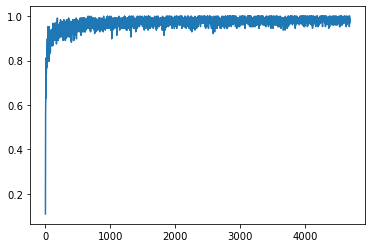

In [4]:
mlp = MLP([28*28, 256, 256, 256, 10])
model = NN_classifier(mlp, 10)
model.prepare_data(datasets.MNIST)
model.fit(10)

# &nbsp;
## 6-5. Convolution
### 6-5-1. convolution operation
* $y(i,j) = \sum_{(k,l)\in \{-d,...,+d\}} f(k,l) x(i+k,j+l)$
    * $x(i,j)$ : source (input) pixel
    * $y(i,j)$ : destination (output) pixel
    * $f(k,l)$ : colvolution filter pixel
        * $(2d+1)\times(2d+1)$ : filter size
        * $k, l \in \{-d, ..., +d\}$

### 6-5-2. Convolution is quite a successful technique in image processing
- heavily depends on the choice of convolution filters
    * which filters to use?
        * vertical/horizontal edge detector
        * circle detector, corner detector, ...
    * feature engineering on the result of convolution : not generic
        * hand-crafted task-specific features : time consuming
            * features for cat classfier : pointed ear, eye distance, nose, ...
    * a general approach : a model that can __learn features from data__
        * __representation learning__: learn good feature representation
        * usually deep NN is used $\to$ __deep learning__

<img src="figures/Ch6.Convolution.png" width=800>

### 6-5-3. Max-Pooling
- to reduce image size $\Rightarrow$ condensed information
- sub-sampling (down-sampling) by taking maximum 

<img src="figures/Ch6.Max-pooling.png" width=400>

### 6-5-4. CNN : Convolutional Neural Network architecture
<img src="figures/Ch6.CNN.png" width=800>

<img src="figures/Ch6.CNN accuracy.png" width=800>

In [5]:
class CNN(nn.Module):
    def __init__(self, i_size, i_channels, D_out):
        super().__init__()
        o1_channels = 4*i_channels
        self.block1 = nn.Sequential(
            nn.Conv2d(i_channels, o1_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(o1_channels),
            nn.ReLU(),
            nn.MaxPool2d(2))
        o1_size = i_size // 2  # padding=2 -> no size reduction
        o2_channels = 4*o1_channels
        self.block2 = nn.Sequential(
            nn.Conv2d(o1_channels, o2_channels, kernel_size=5, padding=0),
            nn.BatchNorm2d(o2_channels),
            nn.ReLU(),
            nn.MaxPool2d(2))
        o2_size = (o1_size - 4) // 2  # padding=0
        G = o2_size*o2_size*o2_channels
        self.block3 = nn.Sequential(nn.Linear(G, G*2), nn.ReLU(), nn.Linear(G*2, D_out))

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = out.view(out.size(0), -1)
        out = self.block3(out)
        return out

In [7]:
cnn = CNN(28, 1, 10)
model = NN_classifier(cnn, 10)
model.prepare_data(datasets.MNIST)
model.fit(50)

Exception ignored in: <function tqdm.__del__ at 0x0000027E2C664310>
Traceback (most recent call last):
  File "c:\programdata\miniconda3\lib\site-packages\tqdm\std.py", line 1152, in __del__
    self.close()
  File "c:\programdata\miniconda3\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### 6-5-4. CNN for Classifying CIFAR-10 data
- Collection of tiny images with labels
    * image size : 32x32, color(rgb 3 channels)
    * 60,000 images : 50,000 for training, 10,000 for test
        * collected and labeled by Alex Krizhevsky, V. Nair, and Geoffrey Hinton
    * 10 class labels : airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
        * 6,000 images per class
- cf. CIFAR-100 : 100 classes, 600 images per class
- CIFAR stands for Canadia Institute for Advanced Research

<img src="figures/Ch6.CIFAR-10.png" width=600>

<img src="figures/Ch6.CIFAR-10 accuracy.png" width=800>

In [ ]:
cnn = CNN(32, 3, 10)
model = NN_classifier(cnn, 10)
model.prepare_optimizer(lr=0.01, wd=0.001)
model.prepare_data(datasets.CIFAR10, batch_size=12500)
model.fit(50)

In [ ]:
model.prepare_optimizer(lr=0.0001, wd=0.001)
model.fit(10)

## __6-6. Deep Learning__?

<img src="figures/Ch6.Deep learning.png" width=800>

<img src="figures/Ch6.Why DNN.png" width=600>

<img src="figures/Ch6.ImageNet.png" width=800>

<img src="figures/Ch6.ImageNet Winners.png" width=800>

## __6-7. Regression__ with NN
- __Parametric__ regression
    * assumes parametric form of function family
    * find parameters by optimization
    - simple linear regression
        * $ y_i = w_0 + w_1x_i + \epsilon_i = \textbf{x}_i^T \textbf{w} + \epsilon_i $ 
            * $ \textbf{x}_i = (1, x_i)^T $ : features
            * $ \textbf{w} = (w_0, w_1)^T $ : parameters
    - regression with polynomial of degree p : in parameter vector $ \textbf{w} $ 
        * $ y_i = w_0 + w_1x_i + w_2x_i^2 + ... + w_px_i^p + \epsilon_i = \textbf{x}_i^T \textbf{w} + \epsilon_i $ 
            * $ \textbf{x}_i = (1, x_i, x_i^2,..., x_i^p)^T $ : polynomial features
            * $ \textbf{w} = (w_0, w_1, w_2, ..., w_p)^T $ : parameters
    - regression with special non-linear functions
        * $ y_i = w_0 + \log(x_i-w_1) + \sin(w_2x_i + w_3) + \epsilon_i$

- __Non-parametric__ regression 
    * does not assume parametric functional form
    * examples
        * neural net
        * decision tree
        * Gaussian process

# &nbsp;
### 6-7-1. Sample data for regression
<img src="figures/Ch6.Regression w NN.png" width=800>

### 6-7-2. class NN_regressor
- inherits NN_classifier
    * many methods are common

In [7]:
%matplotlib qt5  
class NN_regressor(NN_classifier):
    def __init__(self, nn_model):
        super().__init__(nn_model, 1)
        self.prepare_optimizer(lr=0.001, wd=0.0001)

    def prepare_N_data(self, n, sigma=0.02):
        X = np.random.rand(n)*4
        Y = 0.5*X + 0.5
        for i in range(n):
            x = X[i]
            if x > 1:
                if x < 2:
                    Y[i] = 0.5*(x-2)**2 + 0.5
                else:
                    Y[i] = np.log(x - 1) + 0.5
        Y += np.random.randn(n)*sigma

        Xt = torch.tensor(X, dtype=torch.float32).view((n,1)).to(self.device)
        Yt = torch.tensor(Y, dtype=torch.float32).view((n,1)).to(self.device)
        return Xt, Yt, X, Y        
        
    def prepare_data(self, batch_size=256):
        self.X_trn, self.Y_trn, self.Xnp_trn, self.Ynp_trn = self.prepare_N_data(5000)
        self.X_tst, self.Y_tst, self.Xnp_tst, self.Ynp_tst = self.prepare_N_data(1000)
        self.batch_size = batch_size
        
    
    def fit_epoch(self):
        self.nn_model.train()
        N = self.X_trn.shape[0]
        m = self.batch_size
        n_batch = N // m
        es_score = 0
        for i in range(n_batch):
            idx = np.random.choice(N, m, replace=False)
            mb_X = self.X_trn[idx,0].view((m,1))
            mb_Y = self.Y_trn[idx,0].view((m,1))
            
            # Forward pass
            Y_hat = self.nn_model(mb_X)
            
            # Compute loss            
            loss = F.mse_loss(mb_Y, Y_hat)

            # Backprop
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            # Track MSE
            score = loss.item()
            self.score_list.append(score)
        
        
    def fit(self, n_epochs=50, plot=True):
        loss_list = []
        self.score_list = []
        plt.ion()
        for i in range(n_epochs):
            self.fit_epoch()
            self.test(f'Training epoch {i} ')
            if plot:
                self.plot_data()

        plt.ioff()
        # plt.plot(self.score_list)


    def plot_data(self):
        self.nn_model.eval()
        with torch.no_grad():
            Yhat_tst = self.nn_model(self.X_tst).cpu().numpy()

        plt.gcf().clear()
        plt.plot(self.Xnp_trn, self.Ynp_trn, 'b.')
        plt.plot(self.Xnp_tst, Yhat_tst, 'r.')
        plt.draw()
        plt.pause(0.01)        

        
    def test(self, prefix=''):
        self.nn_model.eval()
        r2 = self.score(self.X_tst, self.Y_tst)
        print(f'{prefix}Test R2 score of the model : {r2:.4f}')

        
    def score(self, X, Y):
        self.nn_model.eval()
        X = X.to(self.device)
        Y = Y.to(self.device)
        Y_hat = self.nn_model(X)
        mse = F.mse_loss(Y, Y_hat)
        var = Y.var()
        r2 = 1 - mse/var
        return r2.detach().item()

    def predict(self, X):
        X = X.to(self.device)
        return self.nn_model(X)

### 6-7-3. Regression with MLP

In [ ]:
H = 64
mlp = MLP([1,H,H,H,H,1])
model = NN_regressor(mlp)
model.prepare_data()
model.fit(n_epochs=50)

### 6-7-4. Effects of hidden layer width and depth
* NN is a univeral approximator
    * NN can approximate any complex decision function within specified tolerance
    * _universal approximation theorem_
<img src="figures/Ch6.NN width & depth.png" width=600>

In [ ]:
H = 8
mlp = MLP([1,H,H,H,H,H,H,H,H,H,H,1])
model = NN_regressor(mlp)
model.prepare_data()
model.fit(n_epochs=100)

# &nbsp;
## 6-8. Optimization for NN learning
### Gradient descent (__GD__)
* $\mathbf{w}_{t+1} \gets \mathbf{w}_t - \alpha_t \nabla_\mathbf{w}L$
* $\alpha_t$ : learning rate, step size
    * how to set $\alpha_t$ : non-trivial
        * easily diverges with large $\alpha_t$  
        * with small enough $\alpha_t$, GD coverges to a local optimum
            * too small $\alpha_t \to $ too slow covergence
        * line search
            * Back-tracking line search method (Amijo rule)
        * 2nd order method (Newton method) : use Hessian $\nabla_\mathbf{w}^2L$
            * BFGS method, L-BFGS method  

### Stochastic gradient descent (__SGD__)
* using a subset of data (mini-batch) to estimate gradient
    * full gradient (gradient with full data) can take too much computation
    * updating $\mathbf{w}_t$ with sample estimates $\hat{\nabla}_\mathbf{w}L$ instead of true gradient $\nabla_\mathbf{w}L$
        * will it converge?
        * yes, under Robbins-Monro Conditions on Stochastic Approximation
            * $\sum_{t=1}^{\infty}\alpha_t^2 < \infty$ ( $\Rightarrow$  decreasing to 0 )
            * $\sum_{t=1}^{\infty}\alpha_t = \infty$ ( $\Rightarrow$  not too fast )
            * R-M conds are satified if $\alpha_t = \frac{1}{t^p}$ where $0.5 < p \leq 1$         

### Adaptive methods
- Momentum
    * $\mathbf{v} \gets \mu\mathbf{v} - \alpha_t \nabla_\mathbf{w}L$
    * $\mathbf{w}_{t+1} \gets \mathbf{w}_t +\mathbf{v}$
- Nesterov Momentum
- Adaptive methods
    - AdaGrad, AdaDelta
    - RProp, RMSProp
    - Adam (Kingma & Ba, 2015) : very popular
    
#### Refer to "Optimization for ML.pdf" for more details

### Optimizers in PyTorch
* torch.optim.SGD(params, lr, momentum, weight_decay)
    * params : parameters $\mathbf{w}$ to optimize
    * lr : (initial) learning rate $\alpha$
    * momentum : $\mu$ (for $\mathbf{v} \gets \mu\mathbf{v} - \alpha_t \nabla_\mathbf{w}L$)
        * default momentum = 0, it is recommended to use momentun=0.9
    * weight_decay : $\lambda$ in L2 regularization 
        * $\min L(\mathbf{w}) + \lambda|\mathbf{w}|^2$
        * default weight_decay = 0
* torch.optim.Adam(parameters, lr, weight_decay) 
    * very popular adaptive method
* torch.optim.LBFGS(parameters, lr, weight_decay)
    * 2nd order method
    * unstable when used with stochastic gradient (gradient from mini-batch of training data)